<a href="https://colab.research.google.com/github/drrao01/gpr2_v01/blob/main/AFM_423_GPR2_v01.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

TO DO (Mark things as completed when done): 

1.   Load in data [COMPLETED]
2.   Data Preprocessing (Merge all data sets, remove days with low volume, make graphs/data viz. regarding price, moneyness, profitability, and volume trends, convert time-to-maturity to hours) [COMPLETED - OUTSTANDING: Data visualization]
3.   Apply Black Scholes Model
4.   Apply simple NN (with factor data and without factor data)
5.   Apply gated NN (with factor data and without factor data)
6.   Create results summary (training times, accuracy, MSE, MAPE, graph of predicted price vs actual price)





In [1]:
import pandas as pd
import numpy as np
import keras
import tensorflow as tf
import matplotlib
import seaborn
import sklearn 
import datetime as dt

In [14]:
url = 'https://raw.githubusercontent.com/drrao01/gpr2_v01/main/Data/spx_eod_201712.txt'
df = pd.read_csv(url, sep=",")
df = df.drop(columns=[' [P_BID]', ' [P_ASK]', ' [P_SIZE]', ' [P_LAST]', ' [P_DELTA]', ' [P_GAMMA]', ' [P_VEGA]', ' [P_THETA]', ' [P_RHO]', ' [P_IV]', ' [P_VOLUME]'])
print(df.shape)

(87340, 22)


In [15]:
df.head()

,[QUOTE_UNIXTIME],[QUOTE_READTIME],[QUOTE_DATE],[QUOTE_TIME_HOURS],[UNDERLYING_LAST],[EXPIRE_DATE],[EXPIRE_UNIX],[DTE],[C_DELTA],[C_GAMMA],...,[C_RHO],[C_IV],[C_VOLUME],[C_LAST],[C_SIZE],[C_BID],[C_ASK],[STRIKE],[STRIKE_DISTANCE],[STRIKE_DISTANCE_PCT]
0,1512162000,2017-12-01 16:00,2017-12-01,16.0,2641.78,2017-12-01,1512162000,0.0,0.99629,0.00001,...,0.03244,5.866160,,0.0,40 x 40,1438.10,1447.20,1200.0,1441.8,0.546
1,1512162000,2017-12-01 16:00,2017-12-01,16.0,2641.78,2017-12-01,1512162000,0.0,0.99659,0.00003,...,0.03563,5.309450,,0.0,40 x 40,1338.11,1347.21,1300.0,1341.8,0.508
2,1512162000,2017-12-01 16:00,2017-12-01,16.0,2641.78,2017-12-01,1512162000,0.0,0.99572,0.00001,...,0.03769,4.792850,,0.0,40 x 40,1238.11,1247.20,1400.0,1241.8,0.470
3,1512162000,2017-12-01 16:00,2017-12-01,16.0,2641.78,2017-12-01,1512162000,0.0,0.99564,-0.00001,...,0.04042,4.310600,,0.0,40 x 40,1138.10,1147.20,1500.0,1141.8,0.432
4,1512162000,2017-12-01 16:00,2017-12-01,16.0,2641.78,2017-12-01,1512162000,0.0,0.99568,0.00000,...,0.04204,4.081200,,0.0,40 x 40,1088.10,1097.21,1550.0,1091.8,0.413


In [16]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 87340 entries, 0 to 87339
Data columns (total 22 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   [QUOTE_UNIXTIME]        87340 non-null  int64  
 1    [QUOTE_READTIME]       87340 non-null  object 
 2    [QUOTE_DATE]           87340 non-null  object 
 3    [QUOTE_TIME_HOURS]     87340 non-null  float64
 4    [UNDERLYING_LAST]      87340 non-null  float64
 5    [EXPIRE_DATE]          87340 non-null  object 
 6    [EXPIRE_UNIX]          87340 non-null  int64  
 7    [DTE]                  87340 non-null  float64
 8    [C_DELTA]              87340 non-null  float64
 9    [C_GAMMA]              87340 non-null  float64
 10   [C_VEGA]               87340 non-null  float64
 11   [C_THETA]              87340 non-null  float64
 12   [C_RHO]                87340 non-null  float64
 13   [C_IV]                 87340 non-null  object 
 14   [C_VOLUME]             87340 non-null

In [17]:
years = list(range(19, 22))
months = list(range(1, 13))

for year in years: 
  for month in months: 
    #print(f'{year} - {month}:')
    if month < 10:
      url = f'https://raw.githubusercontent.com/drrao01/gpr2_v01/main/Data/spx_eod_20{year}0{month}.txt'
    else:
      url = f'https://raw.githubusercontent.com/drrao01/gpr2_v01/main/Data/spx_eod_20{year}{month}.txt'
    df_temp = pd.read_csv(url)
    df_temp = df_temp.drop(columns=[' [P_BID]', ' [P_ASK]', ' [P_SIZE]', ' [P_LAST]', ' [P_DELTA]', ' [P_GAMMA]', ' [P_VEGA]', ' [P_THETA]', ' [P_RHO]', ' [P_IV]', ' [P_VOLUME]'])
    print(f'{year} - {month}: {df_temp.shape}')
    df = df.append(df_temp)

print(df.shape)

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2882: DtypeWarning: Columns (15,17,18,20,21,23) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


19 - 1: (128066, 22)
19 - 2: (109343, 22)
19 - 3: (110807, 22)
19 - 4: (117842, 22)
19 - 5: (116178, 22)
19 - 6: (112336, 22)
19 - 7: (128786, 22)
19 - 8: (126689, 22)
19 - 9: (106921, 22)
19 - 10: (132203, 22)
19 - 11: (125946, 22)
19 - 12: (137145, 22)
20 - 1: (141027, 22)
20 - 2: (132836, 22)


/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2882: DtypeWarning: Columns (29) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


20 - 3: (182489, 22)
20 - 4: (149674, 22)
20 - 5: (122921, 22)
20 - 6: (140718, 22)
20 - 7: (144085, 22)
20 - 8: (138634, 22)
20 - 9: (154709, 22)
20 - 10: (150346, 22)
20 - 11: (129871, 22)
20 - 12: (149467, 22)
21 - 1: (143231, 22)


/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2882: DtypeWarning: Columns (15,17,18) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


21 - 2: (138022, 22)
21 - 3: (179050, 22)
21 - 4: (175555, 22)
21 - 5: (159887, 22)
21 - 6: (173394, 22)


/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2882: DtypeWarning: Columns (8,9,10,11,12,15,17,18,20,21,23,24,25,26,27,28) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


21 - 7: (178901, 22)
21 - 8: (179878, 22)
21 - 9: (162052, 22)
21 - 10: (191477, 22)
21 - 11: (199887, 22)
21 - 12: (209661, 22)
(5367374, 22)


In [18]:
df.head()

,[QUOTE_UNIXTIME],[QUOTE_READTIME],[QUOTE_DATE],[QUOTE_TIME_HOURS],[UNDERLYING_LAST],[EXPIRE_DATE],[EXPIRE_UNIX],[DTE],[C_DELTA],[C_GAMMA],...,[C_RHO],[C_IV],[C_VOLUME],[C_LAST],[C_SIZE],[C_BID],[C_ASK],[STRIKE],[STRIKE_DISTANCE],[STRIKE_DISTANCE_PCT]
0,1512162000,2017-12-01 16:00,2017-12-01,16.0,2641.78,2017-12-01,1512162000,0.0,0.99629,0.00001,...,0.03244,5.866160,,0.0,40 x 40,1438.1,1447.2,1200.0,1441.8,0.546
1,1512162000,2017-12-01 16:00,2017-12-01,16.0,2641.78,2017-12-01,1512162000,0.0,0.99659,0.00003,...,0.03563,5.309450,,0.0,40 x 40,1338.11,1347.21,1300.0,1341.8,0.508
2,1512162000,2017-12-01 16:00,2017-12-01,16.0,2641.78,2017-12-01,1512162000,0.0,0.99572,0.00001,...,0.03769,4.792850,,0.0,40 x 40,1238.11,1247.2,1400.0,1241.8,0.470
3,1512162000,2017-12-01 16:00,2017-12-01,16.0,2641.78,2017-12-01,1512162000,0.0,0.99564,-0.00001,...,0.04042,4.310600,,0.0,40 x 40,1138.1,1147.2,1500.0,1141.8,0.432
4,1512162000,2017-12-01 16:00,2017-12-01,16.0,2641.78,2017-12-01,1512162000,0.0,0.99568,0.0,...,0.04204,4.081200,,0.0,40 x 40,1088.1,1097.21,1550.0,1091.8,0.413


In [19]:
print(df.columns)
#df.drop(columns=[' [P_BID]', ' [P_ASK]', ' [P_SIZE]', ' [P_LAST]', ' [P_DELTA]', ' [P_GAMMA]', ' [P_VEGA]', ' [P_THETA]', ' [P_RHO]', ' [P_IV]', ' [P_VOLUME]'])

Index(['[QUOTE_UNIXTIME]', ' [QUOTE_READTIME]', ' [QUOTE_DATE]',
       ' [QUOTE_TIME_HOURS]', ' [UNDERLYING_LAST]', ' [EXPIRE_DATE]',
       ' [EXPIRE_UNIX]', ' [DTE]', ' [C_DELTA]', ' [C_GAMMA]', ' [C_VEGA]',
       ' [C_THETA]', ' [C_RHO]', ' [C_IV]', ' [C_VOLUME]', ' [C_LAST]',
       ' [C_SIZE]', ' [C_BID]', ' [C_ASK]', ' [STRIKE]', ' [STRIKE_DISTANCE]',
       ' [STRIKE_DISTANCE_PCT]'],
      dtype='object')


In [20]:
df_processed = df[df[' [DTE]'] >= 48]
df_processed.shape

(2635957, 22)

In [21]:
def calculate_proxy_price(bid, ask):
  return ((bid + ask)/2)

In [22]:
df_processed.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2635957 entries, 2466 to 209660
Data columns (total 22 columns):
 #   Column                  Dtype  
---  ------                  -----  
 0   [QUOTE_UNIXTIME]        int64  
 1    [QUOTE_READTIME]       object 
 2    [QUOTE_DATE]           object 
 3    [QUOTE_TIME_HOURS]     float64
 4    [UNDERLYING_LAST]      float64
 5    [EXPIRE_DATE]          object 
 6    [EXPIRE_UNIX]          int64  
 7    [DTE]                  float64
 8    [C_DELTA]              object 
 9    [C_GAMMA]              object 
 10   [C_VEGA]               object 
 11   [C_THETA]              object 
 12   [C_RHO]                object 
 13   [C_IV]                 object 
 14   [C_VOLUME]             object 
 15   [C_LAST]               object 
 16   [C_SIZE]               object 
 17   [C_BID]                object 
 18   [C_ASK]                object 
 19   [STRIKE]               float64
 20   [STRIKE_DISTANCE]      float64
 21   [STRIKE_DISTANCE_PCT]  float

In [23]:
#df_processed[' [C_ASK]'] = df_processed[' [C_ASK]'].astype(float)
#df_processed[' [C_BID]'] = df_processed[' [C_BID]'].astype(float)
df_processed[' [C_ASK]'] = pd.to_numeric(df_processed[' [C_ASK]'] ,errors='coerce')
df_processed[' [C_BID]'] = pd.to_numeric(df_processed[' [C_BID]'] ,errors='coerce')
df_processed.info()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


<class 'pandas.core.frame.DataFrame'>
Int64Index: 2635957 entries, 2466 to 209660
Data columns (total 22 columns):
 #   Column                  Dtype  
---  ------                  -----  
 0   [QUOTE_UNIXTIME]        int64  
 1    [QUOTE_READTIME]       object 
 2    [QUOTE_DATE]           object 
 3    [QUOTE_TIME_HOURS]     float64
 4    [UNDERLYING_LAST]      float64
 5    [EXPIRE_DATE]          object 
 6    [EXPIRE_UNIX]          int64  
 7    [DTE]                  float64
 8    [C_DELTA]              object 
 9    [C_GAMMA]              object 
 10   [C_VEGA]               object 
 11   [C_THETA]              object 
 12   [C_RHO]                object 
 13   [C_IV]                 object 
 14   [C_VOLUME]             object 
 15   [C_LAST]               object 
 16   [C_SIZE]               object 
 17   [C_BID]                float64
 18   [C_ASK]                float64
 19   [STRIKE]               float64
 20   [STRIKE_DISTANCE]      float64
 21   [STRIKE_DISTANCE_PCT]  float

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


In [24]:
df_processed['Price'] = df_processed.apply(lambda row: calculate_proxy_price(row[' [C_BID]'], row[' [C_ASK]']), axis=1)
df_processed.shape

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


(2635957, 23)

In [26]:
df_processed.head()

,[QUOTE_UNIXTIME],[QUOTE_READTIME],[QUOTE_DATE],[QUOTE_TIME_HOURS],[UNDERLYING_LAST],[EXPIRE_DATE],[EXPIRE_UNIX],[DTE],[C_DELTA],[C_GAMMA],...,[C_IV],[C_VOLUME],[C_LAST],[C_SIZE],[C_BID],[C_ASK],[STRIKE],[STRIKE_DISTANCE],[STRIKE_DISTANCE_PCT],Price
2466,1512162000,2017-12-01 16:00,2017-12-01,16.0,2641.78,2018-01-19,1516395600,49.0,1.0,0.0,...,,0.000000,2550.0,11 x 10,2535.70,2542.11,100.0,2541.8,0.962,2538.905
2467,1512162000,2017-12-01 16:00,2017-12-01,16.0,2641.78,2018-01-19,1516395600,49.0,1.0,0.0,...,,,0.0,11 x 9,2435.80,2442.20,200.0,2441.8,0.924,2439.000
2468,1512162000,2017-12-01 16:00,2017-12-01,16.0,2641.78,2018-01-19,1516395600,49.0,1.0,0.0,...,,,0.0,11 x 10,2337.00,2343.41,300.0,2341.8,0.886,2340.205
2469,1512162000,2017-12-01 16:00,2017-12-01,16.0,2641.78,2018-01-19,1516395600,49.0,1.0,0.0,...,,,0.0,11 x 10,2237.29,2243.59,400.0,2241.8,0.849,2240.440
2470,1512162000,2017-12-01 16:00,2017-12-01,16.0,2641.78,2018-01-19,1516395600,49.0,1.0,0.0,...,,,0.0,1 x 1,2129.90,2148.90,500.0,2141.8,0.811,2139.400


In [27]:
def calculate_moneyness(strike, underlying_price):
  return (strike/underlying_price)

In [30]:
df_processed['Moneyness'] = df_processed.apply(lambda row: calculate_moneyness(row[' [STRIKE]'], row[' [UNDERLYING_LAST]']), axis=1)
df_processed.head()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


,[QUOTE_UNIXTIME],[QUOTE_READTIME],[QUOTE_DATE],[QUOTE_TIME_HOURS],[UNDERLYING_LAST],[EXPIRE_DATE],[EXPIRE_UNIX],[DTE],[C_DELTA],[C_GAMMA],...,[C_VOLUME],[C_LAST],[C_SIZE],[C_BID],[C_ASK],[STRIKE],[STRIKE_DISTANCE],[STRIKE_DISTANCE_PCT],Price,Moneyness
2466,1512162000,2017-12-01 16:00,2017-12-01,16.0,2641.78,2018-01-19,1516395600,49.0,1.0,0.0,...,0.000000,2550.0,11 x 10,2535.70,2542.11,100.0,2541.8,0.962,2538.905,0.037853
2467,1512162000,2017-12-01 16:00,2017-12-01,16.0,2641.78,2018-01-19,1516395600,49.0,1.0,0.0,...,,0.0,11 x 9,2435.80,2442.20,200.0,2441.8,0.924,2439.000,0.075707
2468,1512162000,2017-12-01 16:00,2017-12-01,16.0,2641.78,2018-01-19,1516395600,49.0,1.0,0.0,...,,0.0,11 x 10,2337.00,2343.41,300.0,2341.8,0.886,2340.205,0.113560
2469,1512162000,2017-12-01 16:00,2017-12-01,16.0,2641.78,2018-01-19,1516395600,49.0,1.0,0.0,...,,0.0,11 x 10,2237.29,2243.59,400.0,2241.8,0.849,2240.440,0.151413
2470,1512162000,2017-12-01 16:00,2017-12-01,16.0,2641.78,2018-01-19,1516395600,49.0,1.0,0.0,...,,0.0,1 x 1,2129.90,2148.90,500.0,2141.8,0.811,2139.400,0.189266


In [32]:
df_processed[' [C_DELTA]'] = pd.to_numeric(df_processed[' [C_DELTA]'] ,errors='coerce')
df_processed[' [C_GAMMA]'] = pd.to_numeric(df_processed[' [C_GAMMA]'] ,errors='coerce')
df_processed[' [C_VEGA]'] = pd.to_numeric(df_processed[' [C_VEGA]'] ,errors='coerce')
df_processed[' [C_THETA]'] = pd.to_numeric(df_processed[' [C_THETA]'] ,errors='coerce')
df_processed[' [C_RHO]'] = pd.to_numeric(df_processed[' [C_RHO]'] ,errors='coerce')
df_processed[' [C_IV]'] = pd.to_numeric(df_processed[' [C_IV]'] ,errors='coerce')
df_processed.info()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documen

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2635957 entries, 2466 to 209660
Data columns (total 24 columns):
 #   Column                  Dtype  
---  ------                  -----  
 0   [QUOTE_UNIXTIME]        int64  
 1    [QUOTE_READTIME]       object 
 2    [QUOTE_DATE]           object 
 3    [QUOTE_TIME_HOURS]     float64
 4    [UNDERLYING_LAST]      float64
 5    [EXPIRE_DATE]          object 
 6    [EXPIRE_UNIX]          int64  
 7    [DTE]                  float64
 8    [C_DELTA]              float64
 9    [C_GAMMA]              float64
 10   [C_VEGA]               float64
 11   [C_THETA]              float64
 12   [C_RHO]                float64
 13   [C_IV]                 float64
 14   [C_VOLUME]             object 
 15   [C_LAST]               object 
 16   [C_SIZE]               object 
 17   [C_BID]                float64
 18   [C_ASK]                float64
 19   [STRIKE]               float64
 20   [STRIKE_DISTANCE]      float64
 21   [STRIKE_DISTANCE_PCT]  float

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys


In [35]:
df_processed[' [QUOTE_DATE]'] = pd.to_datetime(df_processed[' [QUOTE_DATE]'], format='%Y/%m/%d')
df_processed.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2635957 entries, 2466 to 209660
Data columns (total 24 columns):
 #   Column                  Dtype         
---  ------                  -----         
 0   [QUOTE_UNIXTIME]        int64         
 1    [QUOTE_READTIME]       object        
 2    [QUOTE_DATE]           datetime64[ns]
 3    [QUOTE_TIME_HOURS]     float64       
 4    [UNDERLYING_LAST]      float64       
 5    [EXPIRE_DATE]          object        
 6    [EXPIRE_UNIX]          int64         
 7    [DTE]                  float64       
 8    [C_DELTA]              float64       
 9    [C_GAMMA]              float64       
 10   [C_VEGA]               float64       
 11   [C_THETA]              float64       
 12   [C_RHO]                float64       
 13   [C_IV]                 float64       
 14   [C_VOLUME]             object        
 15   [C_LAST]               object        
 16   [C_SIZE]               object        
 17   [C_BID]                float64       
 18  

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [36]:
df_processed.head()

,[QUOTE_UNIXTIME],[QUOTE_READTIME],[QUOTE_DATE],[QUOTE_TIME_HOURS],[UNDERLYING_LAST],[EXPIRE_DATE],[EXPIRE_UNIX],[DTE],[C_DELTA],[C_GAMMA],...,[C_VOLUME],[C_LAST],[C_SIZE],[C_BID],[C_ASK],[STRIKE],[STRIKE_DISTANCE],[STRIKE_DISTANCE_PCT],Price,Moneyness
2466,1512162000,2017-12-01 16:00,2017-12-01,16.0,2641.78,2018-01-19,1516395600,49.0,1.0,0.0,...,0.000000,2550.0,11 x 10,2535.70,2542.11,100.0,2541.8,0.962,2538.905,0.037853
2467,1512162000,2017-12-01 16:00,2017-12-01,16.0,2641.78,2018-01-19,1516395600,49.0,1.0,0.0,...,,0.0,11 x 9,2435.80,2442.20,200.0,2441.8,0.924,2439.000,0.075707
2468,1512162000,2017-12-01 16:00,2017-12-01,16.0,2641.78,2018-01-19,1516395600,49.0,1.0,0.0,...,,0.0,11 x 10,2337.00,2343.41,300.0,2341.8,0.886,2340.205,0.113560
2469,1512162000,2017-12-01 16:00,2017-12-01,16.0,2641.78,2018-01-19,1516395600,49.0,1.0,0.0,...,,0.0,11 x 10,2237.29,2243.59,400.0,2241.8,0.849,2240.440,0.151413
2470,1512162000,2017-12-01 16:00,2017-12-01,16.0,2641.78,2018-01-19,1516395600,49.0,1.0,0.0,...,,0.0,1 x 1,2129.90,2148.90,500.0,2141.8,0.811,2139.400,0.189266


In [37]:
df_processed = df.dropna(subset=[' [C_IV]'])
df_processed.shape

(5367374, 22)

In [ ]:
def 

87


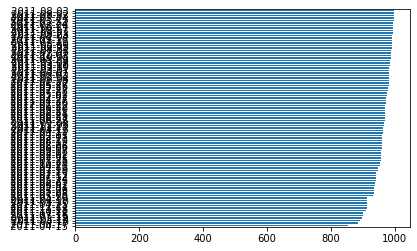

In [ ]:
less_than_1000_transactions = df[' [QUOTE_DATE]'].value_counts(ascending=True).loc[lambda x : x<1000]
print(less_than_1000_transactions.shape[0])
df[' [QUOTE_DATE]'].value_counts(ascending=True)[:less_than_1000_transactions.shape[0]].plot(kind='barh')

BLACK-SCHOLES

Good reference link to Black Scholes Model: https://medium.com/swlh/calculating-option-premiums-using-the-black-scholes-model-in-python-e9ed227afbee

In [ ]:
dat = pd.read_csv('spx_eod_202101.csv', low_memory=False)

dat = dat.rename(columns={' [UNDERLYING_LAST]':'SPOT', ' [DTE]':'TIME', ' [C_IV]':'VLTY',
                          ' [STRIKE]':'STRIKE', ' [C_BID]':'BID', ' [C_ASK]':'ASK'})
dat = dat[['SPOT', 'STRIKE', 'TIME', 'VLTY', 'BID', 'ASK']]

ParserError: ignored